<a href="https://colab.research.google.com/github/20toduc01/norfair-pp/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install norfair++

In [1]:
!git clone https://github.com/20toduc01/norfair-pp.git
%cd norfair-pp
!curl https://gitlab.com/libeigen/eigen/-/archive/3.4.0/eigen-3.4.0.zip -o eigen-3.4.0.zip
!unzip -qq eigen-3.4.0
!cp -r eigen-3.4.0/Eigen ./norfair_pp/Eigen
!rm -rf eigen-3.4.0*
!pip3 install pybind11
!python3 setup.py install

Cloning into 'norfair-pp'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 136 (delta 72), reused 101 (delta 40), pack-reused 0
Receiving objects: 100% (136/136), 2.26 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (72/72), done.
/content/norfair-pp
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3613k    0 3613k    0     0  12.9M      0 --:--:-- --:--:-- --:--:-- 12.9M
     |████████████████████████████████| 210 kB 7.4 MB/s 
running install
running bdist_egg
running egg_info
creating norfair_pp.egg-info
writing norfair_pp.egg-info/PKG-INFO
writing dependency_links to norfair_pp.egg-info/dependency_links.txt
writing top-level names to norfair_pp.egg-info/top_level.txt
writing manifest file 'norfair_pp.egg-info/SOURCES.txt'
writing manifest file 'norfair_pp.egg-info/SOUR

## Load yolov5s from PyTorch Hub

In [2]:
import torch
# Attempt load
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2022-1-18 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)



  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



  0%|          | 0.00/14.0M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


### At this point, you have to restart the runtime for new libraries to work (Ctrl + M + .)

## Object detection + tracking

### Load the model (again) and initialize the tracker

In [4]:
import torch
from norfair_pp import Tracker
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
tracker = Tracker(
    20.0, # Distance threshold
    10, # Min hit count
    25,# Max hit count
    10, # Initialization delay
    -1 # Initial hit count, default to (max hit + min hit)/2
)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-1-18 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


### Inference on sample video

In [5]:
import cv2
import numpy as np

from time import perf_counter


cap = cv2.VideoCapture('norfair-pp/media/traffic.mp4')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), fps, (frame_width,frame_height))

# Measure infer and track time
infer_time = []
track_time = []

# Process video
while(True):
    ret, frame = cap.read()
    if ret != True:
        break

    start = perf_counter()
    # Inference
    results = model(frame).xyxy[0]
    infer_time.append((perf_counter() - start)*1000)

    start = perf_counter()
    # Get centers of boxes
    results = results[:, :4]
    centers = (results[:, :2] + results[:, 2:])/2
    centers = centers.cpu().tolist()
    # Actual tracker update call
    track_results = tracker.update(centers, 1)
    track_time.append((perf_counter() - start)*1000)
    
    # Visualization
    for ID, c in zip(track_results, centers):
        x, y = int(c[0]), int(c[1])
        frame = cv2.circle(frame, (x, y), radius=3, color=(0, 0, 255), thickness=-1)
        frame = cv2.putText(frame, str(ID), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255)

    out.write(frame)

# Release cv2 objects
cap.release()
out.release()


Now you can download `output.avi` to view the results or view it [here](https://youtu.be/GPeYwYejRUQ).

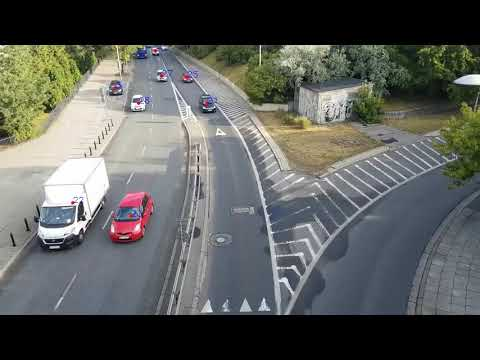

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('GPeYwYejRUQ')

### Speed measurement

In [ ]:
print(f"Average infer time per frame: {sum(infer_time)/len(infer_time)}ms")

Average infer time per frame: 14.357996251016953ms


In [ ]:
print(f"Average track time per frame: {sum(track_time)/len(track_time)}ms")

Average track time per frame: 0.021118570852104435ms
